Football (or soccer to my American readers) is full of clichés: "It's a game of two halves", "taking it one game at a time" and "Liverpool have failed to win the Premier League". You're less likely to hear "Treating the number of goals scored by each team as independent Poisson processes, statistical modelling suggests that the home team have a 60% chance of winning today". But this is actually a bit of cliché too (it has been discussed [here](https://www.pinnacle.com/en/betting-articles/soccer/how-to-calculate-poisson-distribution), [here](https://help.smarkets.com/hc/en-gb/articles/115001457989-How-to-calculate-Poisson-distribution-for-football-betting), [here](http://pena.lt/y/2014/11/02/predicting-football-using-r/), [here](http://opisthokonta.net/?p=296) and [particularly well here](https://dashee87.github.io/data%20science/football/r/predicting-football-results-with-statistical-modelling/)). As we'll discover, a simple Poisson model is, well, overly simplistic. But it's a good starting point and a nice intuitive way to learn about statistical modelling. So, if you came here looking to make money, [I hear this guy makes £5000 per month without leaving the house](http://www.make5000poundspermonth.co.uk/).

## Poisson Distribution

The model is founded on the number of goals scored/conceded by each team. Teams that have been higher scorers in the past have a greater likelihood of scoring goals in the future. We'll import all match results from the recently concluded Premier League (2016/17) season. There's various sources for this data out there ([kaggle](https://www.kaggle.com/hugomathien/soccer), [football-data.co.uk](http://www.football-data.co.uk/englandm.php), [github](https://github.com/jalapic/engsoccerdata), [API](http://api.football-data.org/index)). I built an [R wrapper for that API](https://github.com/dashee87/footballR), but I'll go the csv route this time around. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from scipy.stats import poisson,skellam

epl_1617 = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
epl_1617 = epl_1617[['HomeTeam','AwayTeam','FTHG','FTAG']]
epl_1617 = epl_1617.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl_1617.head()

,HomeTeam,AwayTeam,HomeGoals,AwayGoals
0,Burnley,Swansea,0,1
1,Crystal Palace,West Brom,0,1
2,Everton,Tottenham,1,1
3,Hull,Leicester,2,1
4,Man City,Sunderland,2,1


We imported a csv as a pandas dataframe, which contains various information for each of the 380 EPL games in the 2016-17 English Premier League season. We restricted the dataframe to the columns in which we're interested (specifically, team names and numer of goals scored by each team). I'll omit most of the code that produces the graphs in this post. But don't worry, you can find that code on [my github page](https://github.com/dashee87/blogScripts/blob/master/jupyter/2017-06-04-predicting-football-results-with-statistical-modelling.ipynb). Our task is to model the final round of fixtures in the season, so we must remove the last 10 rows (each gameweek consists of 10 matches).

In [2]:
epl_1617 = epl_1617[:-10]
epl_1617.mean()

HomeGoals    1.591892
AwayGoals    1.183784
dtype: float64

You'll notice that, on average, the home team scores more goals than the away team. This is the so called 'home (field) advantage' (discussed [here](https://jogall.github.io/2017-05-12-home-away-pref/)) and [isn't specific to soccer](http://bleacherreport.com/articles/1803416-is-home-field-advantage-as-important-in-baseball-as-other-major-sports). This is a convenient time to introduce the [Poisson distribution](https://en.wikipedia.org/wiki/Poisson_distribution). It's a discrete probability distribution that describes the probability of the number of events within a specific time period (e.g 90 mins) with a known average rate of occurrence. A key assumption is that the number of events is independent of time. In our context, this means that goals don't become more/less likely by the number of goals already scored in the match. Instead, the number of goals is expressed purely as function an average rate of goals. If that was unclear, maybe this mathematical formulation will make clearer:

$$
P\left( x \right) = \frac{e^{-\lambda} \lambda ^x }{x!}, \lambda>0
$$

$\lambda$ represents the average rate (e.g. average number of goals, average number of letters you receive, etc.). So, we can treat the number of goals scored by the home and away team as two independent Poisson distributions. The plot below shows the proportion of goals scored compared to the number of goals estimated by the corresponding Poisson distributions.

/home/groninge/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


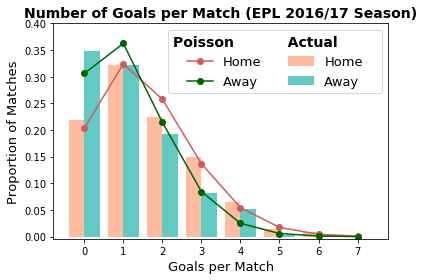

In [3]:
# construct Poisson  for each mean goals value
poisson_pred = np.column_stack([[poisson.pmf(i, epl_1617.mean()[j]) for i in range(8)] for j in range(2)])

# plot histogram of actual goals
plt.hist(epl_1617[['HomeGoals', 'AwayGoals']].values, range(9), 
         alpha=0.7, label=['Home', 'Away'],normed=True, color=["#FFA07A", "#20B2AA"])

# add lines for the Poisson distributions
pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,0],
                  linestyle='-', marker='o',label="Home", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_pred[:,1],
                  linestyle='-', marker='o',label="Away", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson           Actual        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Match",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Match (EPL 2016/17 Season)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()

We can use this statistical model to estimate the probability of specfic events.

$$
\begin{align*}
P(\geq 2|Home) &= P(2|Home) + P(3|Home) + ...\\
        &= 0.258 + 0.137 + ...\\
        &= 0.47
\end{align*}
$$

The probability of a draw is simply the sum of the events where the two teams score the same amount of goals.

$$
\begin{align*}
P(Draw) &= P(0|Home) \times P(0|Away) + P(1|Home) \times P(1|Away) + ...\\
        &= 0.203 \times 0.306 + 0.324 \times 0.362 + ...\\
        &= 0.248
\end{align*}
$$

Note that we consider the number of goals scored by each team to be independent events (i.e. P(A n B) = P(A) P(B)). The difference of two Poisson distribution is actually called a [Skellam distribution](https://en.wikipedia.org/wiki/Skellam_distribution). So we can calculate the probability of a draw by inputting the mean goal values into this distribution.

In [4]:
# probability of draw between home and away team
skellam.pmf(0.0,  epl_1617.mean()[0],  epl_1617.mean()[1])

0.24809376810717076

In [5]:
# probability of home team winning by one goal
skellam.pmf(1,  epl_1617.mean()[0],  epl_1617.mean()[1])

0.22706765807563964

/home/groninge/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


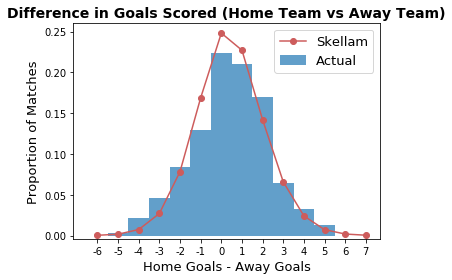

In [6]:
skellam_pred = [skellam.pmf(i,  epl_1617.mean()[0],  epl_1617.mean()[1]) for i in range(-6,8)]

plt.hist(epl_1617[['HomeGoals']].values - epl_1617[['AwayGoals']].values, range(-6,8), 
         alpha=0.7, label='Actual',normed=True)
plt.plot([i+0.5 for i in range(-6,8)], skellam_pred,
                  linestyle='-', marker='o',label="Skellam", color = '#CD5C5C')
plt.legend(loc='upper right', fontsize=13)
plt.xticks([i+0.5 for i in range(-6,8)],[i for i in range(-6,8)])
plt.xlabel("Home Goals - Away Goals",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Difference in Goals Scored (Home Team vs Away Team)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.26])
plt.tight_layout()
plt.show()

So, hopefully you can see how we can adapt this approach to model specific matches. We just need to know the average number of goals scored by each team and feed this data into a Poisson model. Let's have a look at the distribution of goals scored by Chelsea and Sunderland (teams who finished 1st and last, respectively).

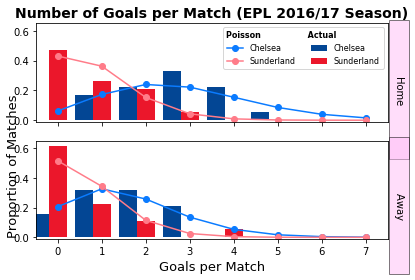

In [26]:
fig,(ax1,ax2) = plt.subplots(2, 1)


chel_home = epl_1617[epl_1617['HomeTeam']=='Chelsea'][['HomeGoals']].apply(pd.value_counts,normalize=True)
chel_home_pois = [poisson.pmf(i,np.sum(np.multiply(chel_home.values.T,chel_home.index.T),axis=1)[0]) for i in range(8)]
sun_home = epl_1617[epl_1617['HomeTeam']=='Sunderland'][['HomeGoals']].apply(pd.value_counts,normalize=True)
sun_home_pois = [poisson.pmf(i,np.sum(np.multiply(sun_home.values.T,sun_home.index.T),axis=1)[0]) for i in range(8)]

chel_away = epl_1617[epl_1617['AwayTeam']=='Chelsea'][['AwayGoals']].apply(pd.value_counts,normalize=True)
chel_away_pois = [poisson.pmf(i,np.sum(np.multiply(chel_away.values.T,chel_away.index.T),axis=1)[0]) for i in range(8)]
sun_away = epl_1617[epl_1617['AwayTeam']=='Sunderland'][['AwayGoals']].apply(pd.value_counts,normalize=True)
sun_away_pois = [poisson.pmf(i,np.sum(np.multiply(sun_away.values.T,sun_away.index.T),axis=1)[0]) for i in range(8)]

ax1.bar(chel_home.index.get_values()-0.4,chel_home.HomeGoals.tolist(),width=0.4,color="#034694",label="Chelsea")
ax1.bar(sun_home.index.get_values(),sun_home.HomeGoals.tolist(),width=0.4,color="#EB172B",label="Sunderland")
pois1, = ax1.plot([i for i in range(8)], chel_home_pois,
                  linestyle='-', marker='o',label="Chelsea", color = "#0a7bff")
pois1, = ax1.plot([i for i in range(8)], sun_home_pois,
                  linestyle='-', marker='o',label="Sunderland", color = "#ff7c89")
leg=ax1.legend(loc='upper right', fontsize=8, ncol=2)
leg.set_title("Poisson                 Actual                ", prop = {'size':'8', 'weight':'bold'})
ax1.set_xlim([-0.5,7.5])
ax1.set_ylim([-0.01,0.65])
ax1.set_xticklabels([])
# mimicing the facet plots in ggplot2 with a bit of a hack
ax1.text(7.65, 0.585, '                Home                ', rotation=-90,
        bbox={'facecolor':'#ffbcf6', 'alpha':0.5, 'pad':5})
ax2.text(7.65, 0.585, '                Away                ', rotation=-90,
        bbox={'facecolor':'#ffbcf6', 'alpha':0.5, 'pad':5})

ax2.bar(chel_away.index.get_values()-0.4,chel_away.AwayGoals.tolist(),width=0.4,color="#034694",label="Chelsea")
ax2.bar(sun_away.index.get_values(),sun_away.AwayGoals.tolist(),width=0.4,color="#EB172B",label="Sunderland")
pois1, = ax2.plot([i for i in range(8)], chel_away_pois,
                  linestyle='-', marker='o',label="Chelsea", color = "#0a7bff")
pois1, = ax2.plot([i for i in range(8)], sun_away_pois,
                  linestyle='-', marker='o',label="Sunderland", color = "#ff7c89")
ax2.set_xlim([-0.5,7.5])
ax2.set_ylim([-0.01,0.65])
ax1.set_title("Number of Goals per Match (EPL 2016/17 Season)",size=14,fontweight='bold')
ax2.set_xlabel("Goals per Match",size=13)
ax2.text(-1.15, 0.9, 'Proportion of Matches', rotation=90, size=13)
plt.tight_layout()
plt.show()

## Building A Model

You should now be convinced that the number of goals scored by each team can be approximated by a Poisson distribution. Due to a relatively sample size (each team plays at most 19 home/away games), the accuracy of this approximation can vary significantly (especially earlier in the season when teams have played fewer games). Similar to before, we could now calculate the probability of various events in this Chelsea Sunderland match. But rather than treat each match separately, we'll build a more general Poisson regression model ([what is that?](https://en.wikipedia.org/wiki/Poisson_regression)).

In [37]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf

goal_model_data = pd.concat([epl_1617[['HomeTeam','AwayTeam','HomeGoals']].assign(home=1).rename(
            columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
           epl_1617[['AwayTeam','HomeTeam','AwayGoals']].assign(home=0).rename(
            columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])

poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data, 
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1042.4
Date:                Thu, 07 Jun 2018   Deviance:                       776.11
Time:                        19:50:41   Pearson chi2:                     659.
No. Iterations:                     5   Covariance Type:             nonrobust
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.3725      0.198      1.880      0.060      -0.016       0.761
team[T.Bournemouth]           -0.2891      0.179     -1.612      0.107      -0.641       0.062
team[T.Burnley]               -0.6458      0.200     -3.230      0.001      -1.038      -0.254
team[T.Chelsea]                0.0789      0.162      0.488      0.626      -0.238       0.396
team[T.Crystal Palace]        -0.3865      0.183     -2.107      0.035      -0.746      -0.027
team[T.Everton]               -0.2008      0.173     -1.161      0.246      -0.540       0.138
team[T.Hull]                  -0.7006      0.204     -3.441      0.001      -1.100      -0.302
team[T.Leicester]             -0.4204      0.187     -2.249      0.025      -0.787      -0.054
team[T.Liverpool]              0.0162      0.164      0.099      0.921      -0.306       0.338
team[T.Man City]               0.0117      0.164      0.072      0.943      -0.310       0.334
team[T.Man United]            -0.3572      0.181     -1.971      0.049      -0.713      -0.002
team[T.Middlesbrough]         -1.0087      0.225     -4.481      0.000      -1.450      -0.568
team[T.Southampton]           -0.5804      0.195     -2.976      0.003      -0.963      -0.198
team[T.Stoke]                 -0.6082      0.197     -3.094      0.002      -0.994      -0.223
team[T.Sunderland]            -0.9619      0.222     -4.329      0.000      -1.397      -0.526
team[T.Swansea]               -0.5136      0.192     -2.673      0.008      -0.890      -0.137
team[T.Tottenham]              0.0532      0.162      0.328      0.743      -0.265       0.371
team[T.Watford]               -0.5969      0.197     -3.035      0.002      -0.982      -0.211
team[T.West Brom]             -0.5567      0.194     -2.876      0.004      -0.936      -0.177
team[T.West Ham]              -0.4802      0.189     -2.535      0.011      -0.851      -0.109
opponent[T.Bournemouth]        0.4109      0.196      2.092      0.036       0.026       0.796
opponent[T.Burnley]            0.1657      0.206      0.806      0.420      -0.237       0.569
opponent[T.Chelsea]           -0.3036      0.234     -1.298      0.194      -0.762       0.155
opponent[T.Crystal Palace]     0.3287      0.200      1.647      0.100      -0.062       0.720
opponent[T.Everton]           -0.0442      0.218     -0.202      0.840      -0.472       0.384
opponent[T.Hull]               0.4979      0.193      2.585      0.010       0.120       0.875
opponent[T.Leicester]          0.3369      0.199      1.694      0.090      -0.053       0.727
opponent[T.Liverpool]         -0.0374      0.217     -0.172      0.863      -0.463       0.389
opponent[T.Man City]          -0.0993      0.222     -0.448      0.654      -0.534       0.335
opponent[T.Man United]        -0.4220      0.241     -1.754      0.079      -0.894       0.050
opponent[T.Middlesbrough]  

If you're curious about the `smf.glm(...)` part, you can find more information [here](http://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html) (edit: earlier versions of this post had erroneously employed a Generalised Estimating Equation (GEE)- [what's the difference](https://stats.stackexchange.com/questions/16390/when-to-use-generalized-estimating-equations-vs-mixed-effects-models)). I'm more interested in the values presented in the `coef` column in the model summary table, which are analogous to the slopes in linear regression. Similar to [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression), we take the [exponent of the parameter values](http://www.lisa.stat.vt.edu/sites/default/files/Poisson.and_.Logistic.Regression.pdf). A positive value implies more goals ($e^{x}>1 \forall x > 0$), while values closer to zero represent more neutral effects ($e^{0}=1$). Towards the bottom of the table you might notice that `home` has a `coef` of 0.2969. This captures the fact that home teams generally score more goals than the away team (specifically, $e^{0.2969}$=1.35 times more likely). But not all teams are created equal. Chelsea has an estimate of 0.0789, while the corresponding value for Sunderland is -0.9619 (sort of saying Chelsea (Sunderland) are better (much worse!) scorers than average). Finally, the `opponent*` values penalize/reward teams based on the quality of the opposition. This reflects the defensive strength of each team (Chelsea: -0.3036; Sunderland: 0.3707). In other words, you're less likely to score against Chelsea. Hopefully, that all makes both statistical and intuitive sense.

Let's start making some predictions for the upcoming matches. We simply pass our teams into `poisson_model` and it'll return the expected average number of goals for your team (we need to run it twice- we calculate the expected average number of goals for each team separately). So let's see how many goals we expect Chelsea and Sunderland to score.

In [28]:
poisson_model.predict(pd.DataFrame(data={'team': 'Chelsea', 'opponent': 'Sunderland',
                                       'home':1},index=[1]))

1    3.061662
dtype: float64

In [29]:
poisson_model.predict(pd.DataFrame(data={'team': 'Sunderland', 'opponent': 'Chelsea',
                                       'home':0},index=[1]))

1    0.409373
dtype: float64

Just like before, we have two Poisson distributions. From this, we can calculate the probability of various events. I'll wrap this in a `simulate_match` function.

In [34]:
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam, 
                                                            'opponent': awayTeam,'home':1},
                                                      index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam, 
                                                            'opponent': homeTeam,'home':0},
                                                      index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [home_goals_avg, away_goals_avg]]
    return(np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
simulate_match(poisson_model, 'Chelsea', 'Sunderland', max_goals=3)

array([[0.03108485, 0.01272529, 0.00260469, 0.00035543],
       [0.0951713 , 0.03896054, 0.00797469, 0.00108821],
       [0.14569118, 0.059642  , 0.01220791, 0.00166586],
       [0.14868571, 0.06086788, 0.01245883, 0.0017001 ]])

This matrix simply shows the probability of Chelsea (rows of the matrix) and Sunderland (matrix columns) scoring a specific number of goals. For example, along the diagonal, both teams score the same the number of goals (e.g. P(0-0)=0.031). So, you can calculate the odds of draw by summing all the diagonal entries. Everything below the diagonal represents a Chelsea victory (e.g P(3-0)=0.149), And you can estimate P(Over 2.5 goals) by summing all entries except the four values in the upper left corner. Luckily, we can use basic matrix manipulation functions to perform these calculations.

In [36]:
chel_sun = simulate_match(poisson_model, "Chelsea", "Sunderland", max_goals=10)
# chelsea win
np.sum(np.tril(chel_sun, -1))

0.8885986612364136

In [13]:
# draw
np.sum(np.diag(chel_sun))

0.08409349268649577

In [14]:
# sunderland win
np.sum(np.triu(chel_sun, 1))

0.02696181994285303

Hmm, our model gives Sunderland a 2.7% chance of winning. But is that right? To assess the accuracy of the predictions, we'll compare the probabilities returned by our model against the odds offered by the [Betfair exchange](https://www.betfair.com/exchange/plus/football).

## Sports Betting/Trading

Unlike traditional bookmakers, on betting exchanges (and Betfair isn't the only one- it's just the biggest), you bet against other people (with Betfair taking a commission on winnings). It acts as a sort of stock market for sports events. And, like a stock market, due to the [efficient market hypothesis](https://en.wikipedia.org/wiki/Efficient-market_hypothesis), the prices available at Betfair reflect the true price/odds of those events happening (in theory anyway). Below, I've posted a screenshot of the Betfair exchange on Sunday 21st May (a few hours before those matches started).


![](https://github.com/dashee87/dashee87.github.io/blob/master/images/betfair_exchange.png)


The numbers inside the boxes represent the best available prices and the amount available at those prices. The blue boxes signify back bets (i.e. betting that an event will happen- going long using stock market terminology), while the pink boxes represent lay bets (i.e. betting that something won't happen- i.e. shorting). For example, if we were to bet £100 on Chelsea to win, we would receive the original amount plus 100\*1.13= £13 should they win (of course, we would lose our £100 if they didn't win). Now, how can we compare these prices to the probabilities returned by our model? Well, decimal odds can be converted to the probabilities quite easily: it's simply the inverse of the decimal odds. For example, the implied probability of Chelsea winning is 1/1.13 (=0.885- our model put the probability at 0.889). I'm focusing on decimal odds, but you might also be familiar with [Moneyline (American) Odds](https://www.pinnacle.com/en/betting-articles/educational/odds-formats-available-at-pinnacle-sports) (e.g. +200) and fractional odds (e.g. 2/1). The relationship between decimal odds, moneyline and probability is illustrated in the table below. I'll stick with decimal odds because the alternatives are either unfamiliar to me (Moneyline) or just stupid (fractional odds).


{% include odds_conversion_table.html %}

So, we have our model probabilities and (if we trust the exchange) we know the true probabilities of each event happening. Ideally, our model would identify situations the market has underestimated the chances of an event occurring (or not occurring in the case of lay bets). For example, in a simple coin toss game, imagine if you were offered \$2 for every $1 wagered (plus your stake), if you guessed correctly. The implied probability is 0.333, but any valid model would return a probability of 0.5. The odds returned by our model and the Betfair exchange are compared in the table below.

{% include prob_comparison_table.html %}

Green cells illustrate opportunities to make profitable bets, according to our model (the opacity of the cell is determined by the implied difference). I've highlighted the difference between the model and Betfair in absolute terms (the relative difference may be more relevant for any trading strategy). Transparent cells indicate situations where the exchange and our model are in broad agreement. Strong colours imply that either our model is wrong or the exchange is wrong. Given the simplicity of our model, I'd lean towards the latter.

## Something's Poissony

So should we bet the house on Manchester United? Probably not ([though they did win!](https://www.theguardian.com/football/2017/may/21/manchester-united-crystal-palace-premier-league-match-report)). There's some non-statistical reasons to resist backing them. Keen football fans would notice that these matches represent the final gameweek of the season. Most teams have very little to play for, meaning that the matches are less predictable (especially when they involve unmotivated 'bigger' teams). Compounding that, Man United were set to play Ajax in the Europa Final three days later. [Man United manager, Jose Mourinho, had even confirmed that he would rest the first team, saving them for the much more important final](https://www.theguardian.com/football/2017/may/17/jose-mourinho-manchester-united-last-premier-league-game). In a similar fashion, injuries/suspensions to key players, managerial sackings would render our model inaccurate. Never underestimate the importance of domain knowledge in statistical modelling/machine learning! We could also think of improvements to the model that would [incorporate time when considering previous matches](http://opisthokonta.net/?p=890) (i.e. more recent matches should be weighted more strongly).

Statistically speaking, is a Poisson distribution even appropriate? Our model was founded on the belief that the number goals can be accurately expressed as a Poisson distribution. If that assumption is misguided, then the model outputs will be unreliable. Given a Poisson distribution with mean $\lambda$, then the number of events in half that time period follows a Poisson distribution with mean $\lambda$/2. In football terms, according to our Poisson model, there should be an equal number of goals in the first and second halves. Unfortunately, that doesn't appear to hold true.

In [31]:
epl_1617_halves = pd.read_csv("http://www.football-data.co.uk/mmz4281/1617/E0.csv")
epl_1617_halves = epl_1617_halves[['FTHG', 'FTAG', 'HTHG', 'HTAG']]
epl_1617_halves['FHgoals'] = epl_1617_halves['HTHG'] + epl_1617_halves['HTAG']
epl_1617_halves['SHgoals'] = epl_1617_halves['FTHG'] + epl_1617_halves['FTAG'] - epl_1617_halves['FHgoals']
epl_1617_halves = epl_1617_halves[['FHgoals', 'SHgoals']]
epl_1617_halves.mean()

FHgoals    1.215789
SHgoals    1.584211
dtype: float64

/home/groninge/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


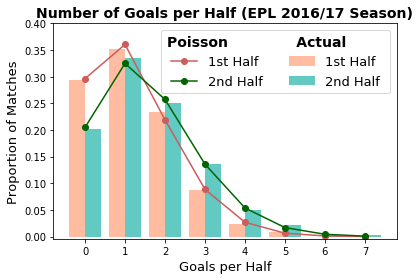

In [32]:
poisson_halves_pred = np.column_stack([[poisson.pmf(i, epl_1617_halves.mean()[j]) for i in range(8)] for j in range(2)])

plt.hist(epl_1617_halves.values, range(9), 
         alpha=0.7, label=['1st Half', '2nd Half'],normed=True, color=["#FFA07A", "#20B2AA"])

pois1, = plt.plot([i-0.5 for i in range(1,9)], poisson_halves_pred[:,0],
                  linestyle='-', marker='o',label="1st Half", color = '#CD5C5C')
pois2, = plt.plot([i-0.5 for i in range(1,9)], poisson_halves_pred[:,1],
                  linestyle='-', marker='o',label="2nd Half", color = '#006400')

leg=plt.legend(loc='upper right', fontsize=13, ncol=2)
leg.set_title("Poisson              Actual        ", prop = {'size':'14', 'weight':'bold'})

plt.xticks([i-0.5 for i in range(1,9)],[i for i in range(9)])
plt.xlabel("Goals per Half",size=13)
plt.ylabel("Proportion of Matches",size=13)
plt.title("Number of Goals per Half (EPL 2016/17 Season)",size=14,fontweight='bold')
plt.ylim([-0.004, 0.4])
plt.tight_layout()
plt.show()


We have irrefutable evidence that violates a fundamental assumption of our model, rendering this whole post as pointless as Sunderland!!! Or we can build on our crude first attempt. Rather than a simple univariate Poisson model, we might have [more success](http://www.ajbuckeconbikesail.net/wkpapers/Airports/MVPoisson/soccer_betting.pdf) with a [bivariate Poisson distriubtion](http://www.stat-athens.aueb.gr/~karlis/Bivariate%20Poisson%20Regression.pdf). The [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution) has also been proposed as a [viable alternative](http://www.sportstradingnetwork.com/article/journal/using-the-weibull-count-distribution-for-predicting-the-results-of-football-matches/). These might be topics for future blog posts.

## Summary

We built a simple Poisson model to predict the results of English Premier League matches. Despite its inherent flaws, it recreates several features that would be a necessity for any predictive football model (home advantage, varying offensive strengths and opposition quality). In conclusion, don't wager the rent money, but it's a good starting point for more sophisticated realistic models. Thanks for reading!